In [1]:
import pandas as pd
data = pd.read_parquet('TRAIN_Reco_2021_2022_2023.parquet.gzip').reset_index()
data.head()

,ExecutionTime,ID,high,low,close,volume
0,2021-01-06 21:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
1,2021-01-06 22:00:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
2,2021-01-06 22:15:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
3,2021-01-06 22:30:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
4,2021-01-06 22:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0


In [2]:
import numpy as np

float_columns = data.select_dtypes(include=['float64', 'float32']).columns
data[float_columns] = data[float_columns].astype(np.float16)

print("Memory usage after conversion:", data.memory_usage(deep=True).sum() / 1024**2, "MB")

Memory usage after conversion: 5325.72522354126 MB


In [3]:
data.shape

(69805344, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69805344 entries, 0 to 69805343
Data columns (total 9 columns):
 #   Column         Dtype                        
---  ------         -----                        
 0   ExecutionTime  datetime64[ns, Europe/Berlin]
 1   ID             object                       
 2   high           float16                      
 3   low            float16                      
 4   close          float16                      
 5   volume         float16                      
 6   Day            object                       
 7   Hour           object                       
 8   Quarter        object                       
dtypes: datetime64[ns, Europe/Berlin](1), float16(4), object(4)
memory usage: 3.1+ GB


**To analyse how trading volume fluctuates as the delivery time approaches**:

This analysis focuses on whether trading activity (volume) increases as the delivery time for specific contracts draws near. You can do this by analyzing the volume for different quarters (Q1, Q2, Q3, Q4) leading up to the delivery time.

In [4]:
# Extract day, hour, and quarter from ID
data['Day'] = data['ID'].str[:3]
data['Hour'] = data['ID'].str[3:5]
data['Quarter'] = data['ID'].str[5:7]

In [9]:
# Group by day, hour, and quarter to see how volume changes leading to delivery
volume_by_delivery = data.groupby(['Day', 'Hour', 'Quarter'])['volume'].mean().reset_index()

# Filter for specific day, e.g., Tuesday ('Tue')
tuesday_volume = volume_by_delivery[volume_by_delivery['Day'] == 'Tue']


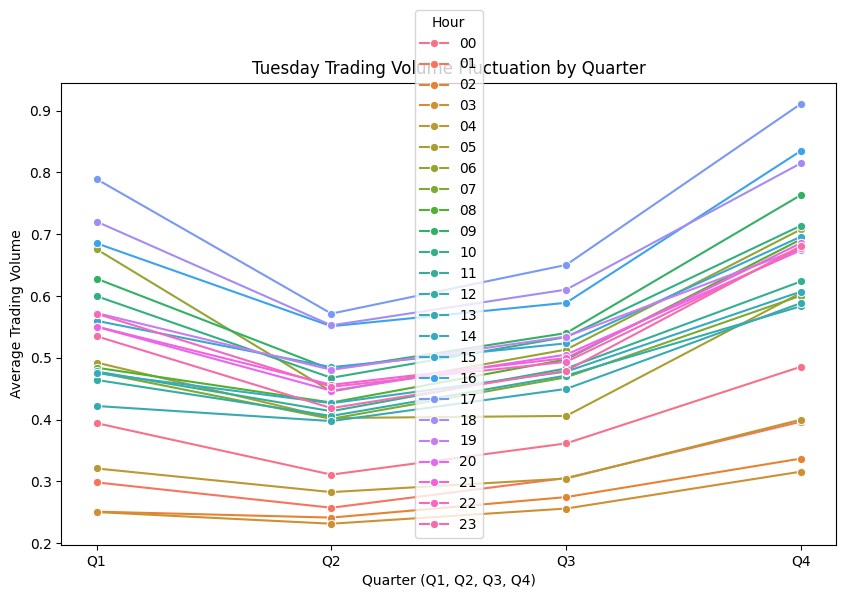

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# If 'tuesday_volume' is a Dask DataFrame, convert it to a Pandas DataFrame
tuesday_volume_pandas = tuesday_volume.compute()

# Plotting trading volume leading up to delivery for Tuesday
plt.figure(figsize=(10, 6))
sns.lineplot(data=tuesday_volume_pandas, x='Quarter', y='volume', hue='Hour', marker='o')
plt.title("Tuesday Trading Volume Fluctuation by Quarter")
plt.xlabel("Quarter (Q1, Q2, Q3, Q4)")
plt.ylabel("Average Trading Volume")
plt.show()

**Takeaways:**

1. **Trading Volume Patterns by Quarter**:
   - For every hour, there is a **dip in trading volume during Q2** (the second quarter of the hour) followed by a gradual increase in Q3 and Q4.
   - The **volume generally rises toward Q4**, which may indicate that traders are more active toward the end of the hour or closer to delivery times, preparing for upcoming events or fulfilling last-minute contracts.

2. **Hour-Specific Trends**:
   - Early morning hours (00 to 06) generally have **lower trading volume**, which is expected as market activity tends to be lower during non-business hours.
   - **Midday hours (10 to 15)** show relatively higher trading volumes across all quarters, indicating this period is more active for trading on Tuesdays.
   - The **early morning hour 05:00** (blue line) stands out with notably higher trading activity, possibly indicating a specific market event or high demand for contracts around this time.

3. **Afternoon Increase**:
   - There is a consistent pattern where trading volume tends to **increase steadily from noon to late afternoon** (12:00 to 18:00), with a particular rise in Q3 and Q4. This might reflect increased trading during business hours as participants adjust their positions based on new market data or external factors such as weather or energy demand.

4. **Symmetry in the Middle of the Hour**:
   - The pattern that shows a dip in Q2 and a rise toward Q4 appears **across most hours**, suggesting that there's less activity in the middle of the hour and a buildup toward the quarter immediately before delivery or the end of the trading period.

To Find the Correlation Between Contracts for Similar Delivery Times

This analysis aims to check if there is any relationship between the prices (High, Low, Close) for contracts with close delivery times. For example, the price of a contract delivering in Q4 might be related to the price of a contract delivering in Q3.

In [6]:
# Create shifted versions of the price data to compare adjacent quarters
data['Close_Q1'] = data['close']
data['Close_Q2'] = data['close'].shift(-1)  # Shift one quarter forward
data['Close_Q3'] = data['close'].shift(-2)  # Shift two quarters forward
data['Close_Q4'] = data['close'].shift(-3)  # Shift three quarters forward

In [7]:
# Calculate correlation between prices of adjacent quarters
correlation_matrix = data[['Close_Q1', 'Close_Q2', 'Close_Q3', 'Close_Q4']].corr()

# Display correlation matrix
print(correlation_matrix)


          Close_Q1  Close_Q2  Close_Q3  Close_Q4
Close_Q1  1.000000  0.985900  0.972235  0.958655
Close_Q2  0.985900  1.000000  0.985900  0.972235
Close_Q3  0.972235  0.985900  1.000000  0.985900
Close_Q4  0.958655  0.972235  0.985900  1.000000


In [14]:
# ! .venv\Scripts\pip install matplotlib

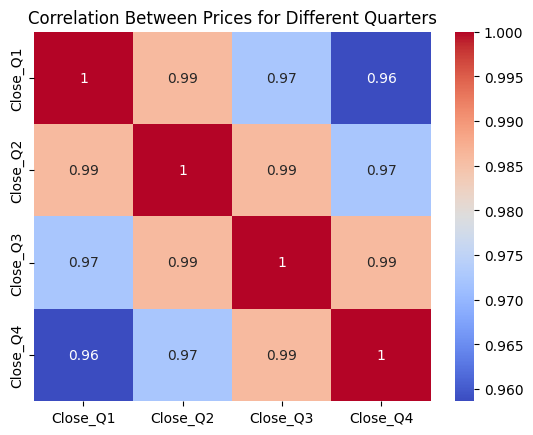

In [15]:
import matplotlib.pyplot as plt

# Plot correlation matrix using heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Between Prices for Different Quarters")
plt.show()


In [11]:
data.head()

,ID,high,low,close,volume,Day,Hour,Quarter,Close_Q1,Close_Q2,Close_Q3,Close_Q4
ExecutionTime,,,,,,,,,,,,
2021-01-06 21:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0,Fri,00,Q1,0.0,0.0,0.0,0.0
2021-01-06 22:00:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0,Fri,00,Q1,0.0,0.0,0.0,0.0
2021-01-06 22:15:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0,Fri,00,Q1,0.0,0.0,0.0,0.0
2021-01-06 22:30:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0,Fri,00,Q1,0.0,0.0,0.0,0.0
2021-01-06 22:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0,Fri,00,Q1,0.0,0.0,0.0,0.0


In [12]:
print("Memory usage:", data.memory_usage(deep=True).sum() / 1024**2, "MB")

Memory usage: 20903.47100830078 MB


In [13]:
import numpy as np

float_columns = data.select_dtypes(include=['float64', 'float32']).columns
data[float_columns] = data[float_columns].astype(np.float16)

print("Memory usage after conversion:", data.memory_usage(deep=True).sum() / 1024**2, "MB")

Memory usage after conversion: 17708.03594970703 MB
